In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [27]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from visual_behavior.data_access import loading as loading

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [29]:
import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.ophys.platform_paper_figures as ppf
import visual_behavior.visualization.utils as utils

### load experiments_table from cache

In [30]:
cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
print(cache_dir)


//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache


In [31]:
experiments_table = loading.get_platform_paper_experiment_table()
print(len(experiments_table))

1249


### limit to containers with all 3 experience levels

In [32]:
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

In [33]:
print(len(experiments_table))

955


#### add useful columns

In [34]:
# experiments_table = utilities.add_cell_type_column(experiments_table)
# experiments_table = utilities.add_experience_exposure_column(experiments_table)
# experiments_table = utilities.add_binned_depth_column(experiments_table)

### get useful info

In [35]:
experience_level = np.sort(experiments_table.experience_level.unique())
print(experience_level)

['Familiar' 'Novel 1' 'Novel >1']


In [36]:
exposures = np.sort(experiments_table.experience_exposure.unique())
print(exposures)

['Familiar 0' 'Familiar 1' 'Familiar 2' 'Familiar 3' 'Familiar > 3'
 'Novel 0' 'Novel 1' 'Novel 2' 'Novel 3' 'Novel > 3']


In [37]:
cell_types = np.sort(experiments_table.cell_type.unique() )
print(cell_types)

['Excitatory' 'Sst Inhibitory' 'Vip Inhibitory']


### get some experiment

In [38]:
# experiment_id = experiments_table.index.values[0]
# dataset = cache.get_behavior_ophys_experiment(experiment_id)

### get multi_session_df

In [39]:
%%time

# set various params
df_name = 'trials_pupil_area_df'
conditions = ['ophys_experiment_id', 'stimulus_change']
use_events = False
filter_events = False

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

# keep changes only
multi_session_df = multi_session_df[multi_session_df.stimulus_change==True]

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))

# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()


1935
952
952
Wall time: 2.39 s


In [42]:
multi_session_df.keys()

Index(['ophys_experiment_id', 'stimulus_change', 'mean_response',
       'sem_response', 'mean_trace', 'sem_trace', 'trace_timestamps',
       'mean_responses', 'mean_baseline', 'sem_baseline', 'peak_response',
       'time_to_peak', 'fano_factor',
       'fraction_significant_p_value_gray_screen',
       'fraction_significant_p_value_omission',
       'fraction_significant_p_value_stimulus', 'reliability',
       'equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'behavior_session_id', 'ophys_container_id',
       'project_code', 'imaging_depth', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'passive',
       'image_set', 'file_id', 'cell_type', 'depth', 'binned_depth',
       'area_depth', 'area_binned_dept

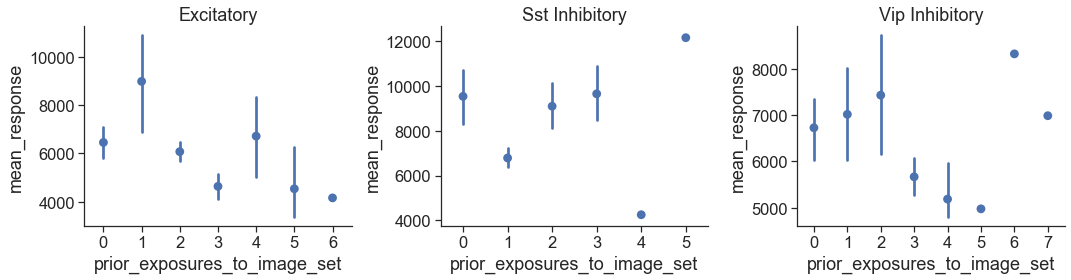

In [43]:
df = multi_session_df.copy()
df = df[df.passive==False]
df['prior_exposures_to_image_set'] = [int(x) for x in df.prior_exposures_to_image_set.values]

fig, ax = plt.subplots(1,3, figsize=(15,4))
for i, cell_type in enumerate(cell_types):
    ax[i] = sns.pointplot(data=df[(df.cell_type==cell_type)&(df.experience_level!='Familiar')],
                  x='prior_exposures_to_image_set', y='mean_response', 
                       join=False, dodge=0.5, ax=ax[i])
    ax[i].set_title(cell_type)
#     ax[i].legend(title='', fontsize='small', bbox_to_anchor=(1,1))
fig.tight_layout()

### limit to containers with all exp levels, most recent familiar and second novel active

In [44]:
multi_session_df = utilities.limit_to_last_familiar_second_novel_active(multi_session_df)
multi_session_df = utilities.limit_to_containers_with_all_experience_levels(multi_session_df)

### look at averages

(0, 12072.37474892393)

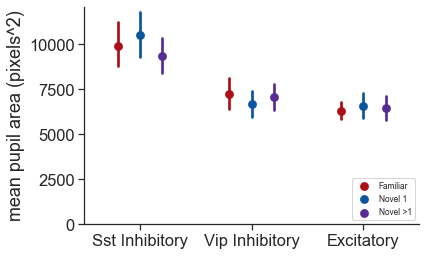

In [45]:
palette = utils.get_experience_level_colors()
experience_levels = np.sort(multi_session_df.experience_level.unique())

fig, ax = plt.subplots()
ax = sns.pointplot(data=multi_session_df, x='cell_type', y='mean_response', hue='experience_level', 
             hue_order=experience_levels, palette=palette, join=False, dodge=0.4, ax=ax)
ax.legend(loc='lower right', fontsize='small', title='')
ax.set_xlabel('')
ax.set_ylabel('mean pupil area (pixels^2)')
ax.set_ylim(ymin=0)

In [ ]:
df = multi_session_df.copy()
# plot
project_code = 'VisualBehaviorMultiscope'
# get timestamps 
multiscope_expt = experiments_table[experiments_table.project_code==project_code].index.values[9] 
timestamps = ppf.get_timestamps_for_response_df_type(cache, multiscope_expt, df_name)

axes_column = 'cell_type'
hue_column = 'experience_level'
palette = utilities.get_experience_level_colors()
xlim_seconds = [-1,1.5]

tmp = df[df.project_code==project_code]
# df = df[df.experience_level!='Novel >1']
# df = df[df.pref_stim==True]

ppf.plot_population_averages_for_conditions(tmp, df_name, timestamps, 
                                            axes_column, hue_column, project_code=project_code,
                                            use_events=use_events, filter_events=filter_events, 
                                            xlim_seconds=xlim_seconds, palette=palette,
                                            horizontal=False, save_dir=None, folder=None)

### population averages

In [ ]:
tmp

In [ ]:
df = multi_session_df.copy()
df = utilities.limit_to_last_familiar_second_novel_active(df)
df = utilities.limit_to_containers_with_all_experience_levels(df)

tmp = df.reset_index(drop=True)
[len(tmp.iloc[index].mean_trace) for index in tmp.index.values]

In [ ]:
tmp

In [ ]:
df = multi_session_df.copy()
df = utilities.limit_to_last_familiar_second_novel_active(df)
df = utilities.limit_to_containers_with_all_experience_levels(df)

project_code = 'VisualBehaviorMultiscope'
# get timestamps 
multiscope_expt = experiments_table[experiments_table.project_code==project_code].index.values[9] 
timestamps = ppf.get_timestamps_for_response_df_type(cache, multiscope_expt, df_name)

axes_column = 'cell_type'
hue_column = 'experience_level'
palette = utilities.get_experience_level_colors()
xlim_seconds = [-1,1.5]

tmp = df[(df.project_code==project_code)]
# df = df[df.experience_level!='Novel >1']
# df = df[df.pref_stim==True]

tmp = tmp.reset_index(drop=True)
indices = [index for index in tmp.index if len(tmp.iloc[index].mean_trace) == len(tmp.mean_trace.values[1000])]
tmp = tmp.loc[indices]

ppf.plot_population_averages_for_conditions(tmp, df_name, timestamps, 
                                            axes_column, hue_column, project_code=project_code,
                                            use_events=use_events, filter_events=filter_events, 
                                            xlim_seconds=xlim_seconds, palette=palette,
                                            horizontal=False, save_dir=None, folder=None)